In [1]:
!pip install nlp
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install nlp
!pip install beautifulsoup4 requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import spacy
from itertools import chain
nlp = spacy.load("en_core_web_lg")
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from itertools import chain

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/imdb dataset.csv'

# Open the file with error handling
with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
    content = file.read()

# Load the content into a DataFrame
from io import StringIO
df = pd.read_csv(StringIO(content))

# Display the dataframe
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Removing the html strips and specific tags
def strip_html(text):
    # Remove specific tags
    text = re.sub(r'<br\s*/?>', ' ', text)
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(separator=" ")

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if remove_digits else r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Remove extra whitespace and newline characters
def remove_extra_whitespace(text):
    text = text.replace('\n', ' ').replace('\r', ' ')
    return re.sub(r'\s+', ' ', text).strip()

# Handle contractions
def handle_contractions(text):
    contractions = {
        "there's": "there is",
        "it's": "it is",
        "can't": "cannot",
        "won't": "will not",
        "I'm": "I am",
        "he's": "he is",
        "she's": "she is",
        "they're": "they are",
        "we're": "we are",
        "you're": "you are",
        "I've": "I have",
        "you've": "you have",
        "we've": "we have",
        "they've": "they have",
        "I'd": "I would",
        "you'd": "you would",
        "he'd": "he would",
        "she'd": "she would",
        "we'd": "we would",
        "they'd": "they would",
        "I'll": "I will",
        "you'll": "you will",
        "he'll": "he will",
        "she'll": "she will",
        "we'll": "we will",
        "they'll": "they will",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "hasn't": "has not",
        "haven't": "have not",
        "hadn't": "had not",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "won't": "will not",
        "wouldn't": "would not",
        "can't": "cannot",
        "couldn't": "could not",
        "shouldn't": "should not",
        "mightn't": "might not",
        "mustn't": "must not"
    }
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

In [6]:

# Pre-process text function to handle sentence splitting
def preprocess_texts(texts):
    processed_texts = []

    for text in texts:
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        text = handle_contractions(text)
        text = remove_special_characters(text)
        text = remove_extra_whitespace(text)

        doc = nlp(text)
        for sent in doc.sents:
            tokens = [token.lemma_.lower() for token in sent if not token.is_stop and not token.is_punct]
            processed_texts.append(tokens)

    return processed_texts

In [7]:
# Example usage
texts = ["<html>This is a sample text.</html>", "Another [example] text with special characters!", "There's a dog's that mustn't be smashed."]
processed = preprocess_texts(texts)
print(processed)

[['sample', 'text'], ['text', 'special', 'character'], ['s', 'dog', 'smash']]


In [8]:
first_10_rows = df.head(10)

In [9]:
# Preprocess the 'review' column
first_10_rows['processed'] = first_10_rows['review'].apply(lambda x: preprocess_texts([x])).tolist()

<ipython-input-9-fff64fc432a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_10_rows['processed'] = first_10_rows['review'].apply(lambda x: preprocess_texts([x])).tolist()


In [10]:
first_10_rows.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [11]:
first_10_rows.processed[3]

[['basically',
  'family',
  'little',
  'boy',
  'jake',
  'think',
  'zombie',
  'closet',
  'parent',
  'fight',
  'time',
  'movie',
  'slow',
  'soap',
  'opera',
  'suddenly',
  'jake',
  'decide',
  'rambo',
  'kill',
  'zombie',
  'ok',
  'go',
  'film',
  'decide',
  'thriller',
  'drama',
  'drama',
  'movie',
  'watchable',
  'parent',
  'divorce',
  'argue',
  'like',
  'real',
  'life'],
 ['jake',
  'closet',
  'totally',
  'ruin',
  'film',
  'expect',
  'boogeyman',
  'similar',
  'movie',
  'instead',
  'watch',
  'drama',
  'meaningless',
  'thriller',
  'spot',
  'play',
  'parent',
  'descent',
  'dialog',
  'shot',
  'jake',
  'ignore']]

In [12]:
first_10_rows.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,"[[reviewer, mention, watch, oz, episode, hook,..."
1,A wonderful little production. <br /><br />The...,positive,"[[wonderful, little, production, filming, tech..."
2,I thought this was a wonderful way to spend ti...,positive,"[[think, wonderful, way, spend, time, hot, sum..."
3,Basically there's a family where a little boy ...,negative,"[[basically, family, little, boy, jake, think,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[[petter, matteis, love, time, money, visually..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [13]:
df['processed'] = df['review'].apply(lambda x: preprocess_texts([x])).tolist()

<ipython-input-5-72dff946b8ec>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [14]:
df.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,"[[reviewer, mention, watch, oz, episode, hook,..."
1,A wonderful little production. <br /><br />The...,positive,"[[wonderful, little, production, filming, tech..."
2,I thought this was a wonderful way to spend ti...,positive,"[[think, wonderful, way, spend, time, hot, sum..."
3,Basically there's a family where a little boy ...,negative,"[[basically, family, little, boy, jake, think,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[[petter, matteis, love, time, money, visually..."


In [49]:
df.processed[79]

[['film',
  'take',
  'surprise',
  'habit',
  'find',
  'little',
  'possible',
  'film',
  'attend',
  'trailer',
  'review',
  'provide',
  'spoiler',
  'spoiler',
  'know',
  'enter',
  'theater',
  'documentary',
  'long',
  'marry',
  'couple',
  'imdb',
  'reader',
  'give',
  'rotten',
  'tomatoes',
  'user',
  'rank',
  'critic',
  'average',
  'amazing',
  'underrate',
  'little',
  'gem',
  'filmmaker',
  'doug',
  'block',
  'decide',
  'record',
  'parent',
  'posterity',
  'beginning',
  'film',
  'treat',
  'requisite',
  'interview',
  'parent',
  'outspoken',
  'mother',
  'mina',
  'forthcoming',
  'dad',
  'mike',
  'immediately',
  'find',
  'couple',
  'interesting',
  'idea',
  'filmmaker',
  'mike',
  'minas',
  'son',
  'doug',
  'go',
  'matter',
  'fact',
  'doubt',
  'doug',
  'know',
  'go',
  'life',
  'take',
  'unexpected',
  'twist',
  'turn',
  'beautifully',
  'expressive',
  'film',
  'follow',
  'journey',
  'difficult',
  'verbalize',
  'moved',
  '

In [50]:
df.review[79]

'This film took me by surprise. I make it a habit of finding out as little as possible about films before attending because trailers and reviews provide spoiler after spoiler. All I knew upon entering the theater is that it was a documentary about a long married couple and that IMDb readers gave it a 7.8, Rotten Tomatoes users ranked it at 7.9 and the critics averaged an amazing 8.2! If anything, they UNDERRATED this little gem.<br /><br />Filmmaker Doug Block decided to record his parents "for posterity" and at the beginning of the film we are treated to the requisite interviews with his parents, outspoken mother Mina, and less than forthcoming dad, Mike. I immediately found this couple interesting and had no idea where the filmmaker (Mike & Mina\'s son Doug) was going to take us. As a matter of fact, I doubt that Doug himself knew where he was going with this!<br /><br />Life takes unexpected twists and turns and this beautifully expressive film follows the journey. It is difficult t

In [ ]:
pd.to_pickle(df, '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/imdb_dataset.pkl')

In [6]:
import pandas as pd
from collections import Counter

In [7]:
df1 = pd.read_pickle('/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/imdb_dataset.pkl')
df1.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,"[[reviewer, mention, watch, oz, episode, hook,..."
1,A wonderful little production. <br /><br />The...,positive,"[[wonderful, little, production, filming, tech..."
2,I thought this was a wonderful way to spend ti...,positive,"[[think, wonderful, way, spend, time, hot, sum..."
3,Basically there's a family where a little boy ...,negative,"[[basically, family, little, boy, jake, think,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[[petter, matteis, love, time, money, visually..."


In [8]:
df1.shape

(50000, 3)

In [15]:
df1['processed_flat'] = df1['processed'].apply(lambda x: ' '.join(map(str, x)))
word_counts = Counter(chain.from_iterable(df1.processed_flat.str.split()))
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

In [75]:
# Ensure 'sentiment' column has values 'positive' and 'negative'
positive_words = list(chain.from_iterable(chain.from_iterable(df[df['sentiment'] == 'positive']['processed'])))
negative_words = list(chain.from_iterable(chain.from_iterable(df[df['sentiment'] == 'negative']['processed'])))

# Ensure all elements are strings
positive_words = [word for word in positive_words if isinstance(word, str)]
negative_words = [word for word in negative_words if isinstance(word, str)]

# Create word count dictionaries
positive_word_count = Counter(positive_words)
negative_word_count = Counter(negative_words)

# Sort word count dictionaries
positive_word_count_dict = dict(sorted(positive_word_count.items(), key=lambda item: item[1], reverse=True))
negative_word_count_dict = dict(sorted(negative_word_count.items(), key=lambda item: item[1], reverse=True))

# Create sets of the keys of the sorted word count dictionaries
positive_bag_of_words = set(sorted(positive_word_count_dict.keys()))
negative_bag_of_words = set(sorted(negative_word_count_dict.keys()))

In [78]:
# Print first 25 words for positive_word_count_dict
print("First 25 words in positive_word_count_dict:")
for i, (word, count) in enumerate(positive_word_count_dict.items()):
    if i >= 25:
        break
    print(f"{word}: {count}")

print("\n")

# Print first 25 words for negative_word_count_dict
print("First 25 words in negative_word_count_dict:")
for i, (word, count) in enumerate(negative_word_count_dict.items()):
    if i >= 25:
        break
    print(f"{word}: {count}")


First 25 words in positive_word_count_dict:
film: 49535
movie: 43813
good: 21820
like: 19518
time: 15553
great: 14148
story: 13882
character: 13811
see: 12928
watch: 12696
love: 11513
think: 11025
s: 10336
scene: 9861
play: 9695
know: 9165
life: 8784
people: 8721
way: 8716
find: 8592
come: 8243
look: 7871
man: 7836
go: 7815
get: 7536


First 25 words in negative_word_count_dict:
movie: 56941
film: 43700
like: 23565
bad: 21379
good: 17862
watch: 14783
time: 14579
character: 14147
s: 12051
think: 11988
see: 11667
look: 11240
scene: 11169
story: 10806
go: 9689
know: 9474
people: 9458
thing: 9373
get: 8799
plot: 8340
way: 8207
end: 7985
come: 7955
try: 7557
find: 7234


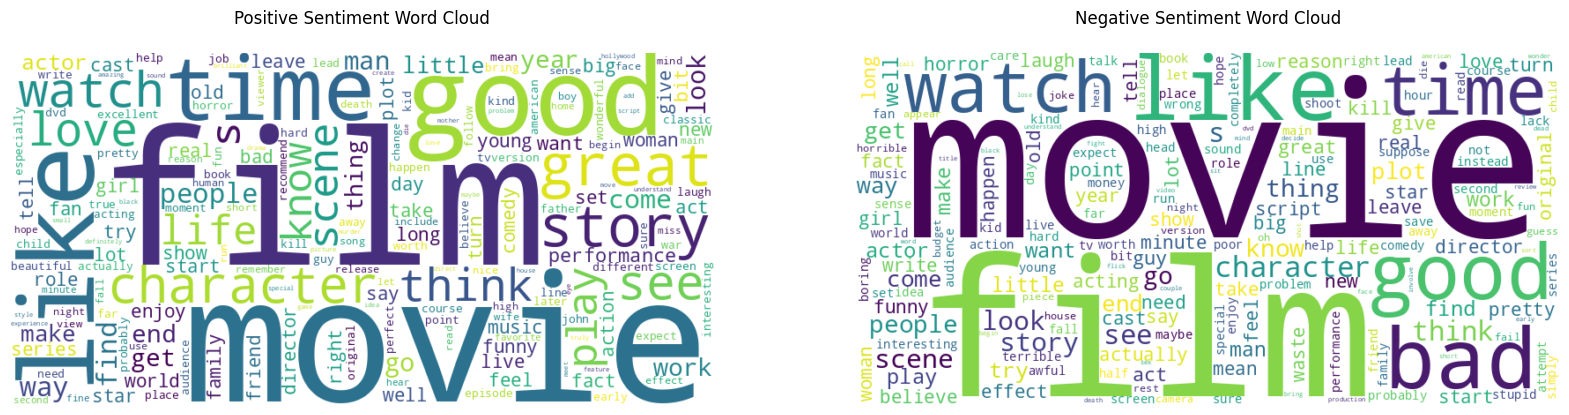

In [83]:
# Generate word cloud for positive_word_count_dict
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_count_dict)

# Generate word cloud for negative_word_count_dict
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_word_count_dict)

# Plotting the word clouds
plt.figure(figsize=(20, 12))

# Positive word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Positive Sentiment Word Cloud\n")
plt.axis('off')

# Negative word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Negative Sentiment Word Cloud\n")
plt.axis('off')

plt.show()

Analyzing the word frequency distributions in positive and negative sentiments reveals key insights into how people express their opinions about films and movies. In positive reviews, terms like "film" (49,535) and "movie" (43,813) dominate, indicating a direct reference to the subject matter. Positive adjectives such as "good" (21,820), "great" (14,148), and "love" (11,513) highlight favorable opinions and strong appreciation. Words like "story" (13,882), "character" (13,811), and "scene" (9,861) suggest that viewers frequently appreciate these elements of films. Additionally, verbs such as "like" (19,518), "watch" (12,696), and "think" (11,025) indicate active engagement and reflection on the films.

In negative reviews, "movie" (56,941) and "film" (43,700) are similarly prevalent, emphasizing the primary subject of critique. However, the presence of "bad" (21,379) along with "good" (17,862) shows the mixed but predominantly critical nature of these reviews. Critical mentions of essential film elements, such as "character" (14,147), "story" (10,806), and "plot" (8,340), likely indicate dissatisfaction with these aspects. Words like "watch" (14,783), "think" (11,988), and "see" (11,667) reflect critical engagement, while terms such as "end" (7,985) and "try" (7,557) point to specific areas where viewers found the films lacking. These patterns help understand the general sentiment and highlight specific aspects that influence viewers' opinions.